In [1]:
import numpy as np
import cv2
import pandas as pd
import os, errno
import matplotlib.pyplot as plt
from scipy import signal

In [2]:
def erodeimg(image):
    kernel = np.ones((4,4), np.uint8)
    erode = cv2.erode(image, kernel, iterations = 1)
    return erode

In [3]:
def dilateimg(image):
    kernel = np.ones((4,4), np.uint8)
    dilate = cv2.dilate(image, kernel, iterations = 1)
    return dilate

In [4]:
def pixelThreshold(image):
    image = np.asarray(image)
    val = image[image > 5]
    count = len(val)
    return count

In [5]:
def listOfVideos(path): 
    video_files = [(os.path.join(root, name), name[0:-4])
                   for root, dirs, files in os.walk(path)
                   for name in files
                   if name.endswith('.mp4')]
    return video_files

In [6]:
def MotionParameters(diff_image):
    eroded = erodeimg(diff_image)
    dilated = dilateimg(eroded)
    pixel = pixelThreshold(dilated)

    mask = cv2.inRange(dilated, 5, 200)   # extract contour and the centroid of the biggest contour
    kernel = np.ones((10, 10), np.uint8)
    closing = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    contours, hierarchy = cv2.findContours(closing, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    areas = [cv2.contourArea(c) for c in contours]
    if (len(contours) >= 1) & np.any(areas):

        max_index = np.argmax(areas)    # Find the index of the largest contour
        contour_basic = contours[max_index]
        contour_hull = cv2.convexHull(contour_basic)

        M = cv2.moments(contour_basic)
        centroid_basic = (int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"]))

        M_hull = cv2.moments(contour_hull)
        centroid_hull = (int(M_hull["m10"] / M_hull["m00"]), int(M_hull["m01"] / M_hull["m00"]))

    else:
        centroid_basic = (np.nan, np.nan)
        centroid_hull = (np.nan, np.nan)


    return pixel, centroid_basic, centroid_hull, contour_hull

In [99]:
path = r"E:\Downloads\ManducaMultiSenseData\Videos"
frame_df = pd.read_csv(r"E:\Downloads\ManducaMultiSenseData\Motion\Centroids_Filtered\window\filteredFrameWindow.csv")
video_files = listOfVideos(path)

In [92]:
names = [i[1] for i in video_files]

In [93]:
names

['L0.1_c-3_m2_0_27647',
 'L0.1_c-3_m32_16_149643',
 'L0.1_c-3_m32_17_154000',
 'L0.1_c-3_m34_14_51383',
 'L0.1_c-3_m34_22_74562',
 'L0.1_c-3_m34_25_81816',
 'L0.1_c-3_m38_4_42921',
 'L0.1_c-3_m40_15_46420',
 'L0.1_c-3_m40_17_65761',
 'L0.1_c-3_m40_9_31581',
 'L0.1_c-3_m41_11_76152',
 'L0.1_c-3_m41_5_58180',
 'L0.1_c-3_m41_6_61746',
 'L0.1_c-3_m41_9_71991',
 'L0.1_c-3_m46_11_39359',
 'L0.1_c-3_m5_12_54487',
 'L0.1_c-3_m5_15_58748',
 'L0.1_c-3_m5_17_60830',
 'L0.1_c-3_m5_18_62363',
 'L0.1_c-3_m5_4_41258',
 'L0.1_c-3_m5_7_47239',
 'L0.1_c-3_m5_8_48961']

In [122]:
for name in names[0:1]:
    
    start, end = frame_df[frame_df.name == name].start_frame.values, frame_df[frame_df.name == name].end_frame.values
    video_name = r"E:\Downloads\ManducaMultiSenseData\Videos\PotentialOutlier\NewSubtract\\" + name + '_testing2.mp4'
    
    
    if name.startswith('L0.1'):
        name = name[:12]
        if name.endswith('_'):
            name = name[:-1]
    elif name.startswith('L50'):
        name = name[:11]
        if name.endswith('_'):
            name = name[:-1]
    v_path = path + "\\" + name + ".mp4"
    
    # declare all variables
    num_pixel = []
    centroid_basic_x = []
    centroid_basic_y = []
    centroid_hull_x = []
    centroid_hull_y = []
    contour_hull = []

    cam = cv2.VideoCapture(v_path)  # load video as object

    back_frame = 0  # calculate background to subtract from frame
    cam.set(1, back_frame)
    ret, f = cam.read(1)  # Read the image at the first frame
    if not ret:
        print(name + ' image not read')
    background = cv2.cvtColor(f, cv2.COLOR_BGR2GRAY)
    
    
    
    frame_seq = np.arange(start,end+1)
    
    
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video = cv2.VideoWriter(video_name, fourcc, 30, (648,488))
    
    b = 0
    
    for frame in frame_seq:
        cam.set(1, frame)  # start processing the current frame
        ret, f = cam.read(1)  # Read the image at that frame
        if not ret:
            print(name + ' frame ' + frame + ' not read')
        
        
        img = cv2.cvtColor(f, cv2.COLOR_BGR2GRAY)
        dif_cv2 = cv2.subtract(img, background)
        
        im, back = img.astype('int32') , background.astype('int32')
        dif_np = im - back
        
        dif_abs_flat = []
        for i in np.ravel(dif_np):
            if (i < 0):

                if (np.absolute(i) > 50):
                    i = np.absolute(i)

                else:
                    i = 0
        
            dif_abs_flat.append(i)
        dif_abs_flat = np.asarray(dif_abs_flat).astype('uint8')
        dif_abs = dif_abs_flat.reshape(488,648)  
        
        
        pixel, cent_b, cent_hull, con_hull = MotionParameters(dif_abs)
        num_pixel.append(pixel)
        centroid_basic_x.append(cent_b[0])
        centroid_basic_y.append(cent_b[1])
        centroid_hull_x.append(cent_hull[0])
        centroid_hull_y.append(cent_hull[1])
        contour_hull.append(con_hull)
    
    

    
    
    
    
        
        
        cv2.circle(f, (int(x_gauss[b]),int(y_gauss[b])), 6, [0,0,255], 3)
        cv2.drawContours(f, [contour_hull[b]], -1, (0, 255, 0), 3)

        video.write(f)
        b+=1
        
    cv2.destroyAllWindows()
    video.release()   



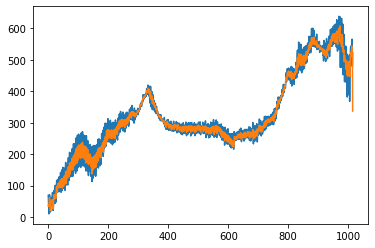

In [109]:
plt.plot(centroid_hull_x)
plt.plot(x_gauss)

In [102]:
v_path

'E:\\Downloads\\ManducaMultiSenseData\\Videos\\L0.1_c-3_m2.mp4'

Text(0.5, 1.0, 'np subtraction (with uint32/c)')

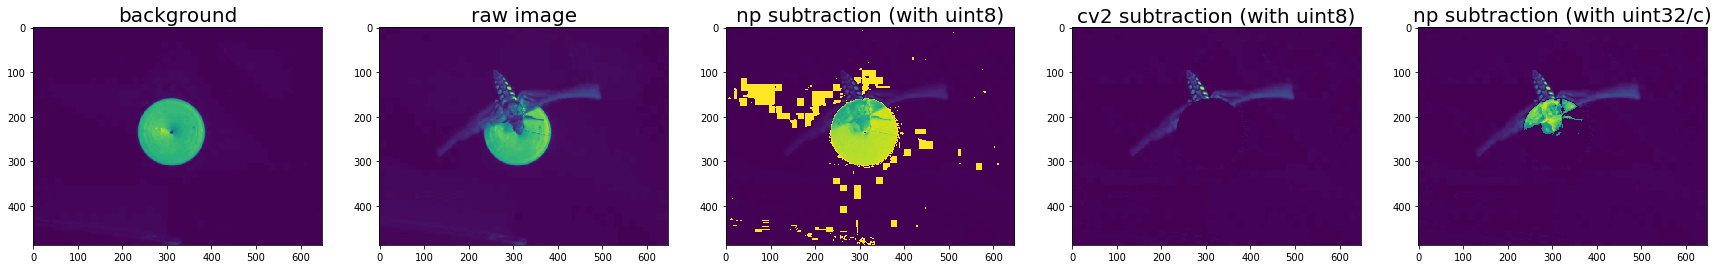

In [10]:
#shadows cause the subtraction of the flower to act up. what about cases where the moth is near the flower
fig, ax = plt.subplots(1,5, figsize = (30,30))
ax[0].imshow(background)
ax[0].set_title("background", size = 20)
ax[1].imshow(img)
ax[1].set_title("raw image", size = 20)
ax[2].imshow(np.subtract(img, background))
ax[2].set_title("np subtraction (with uint8)", size = 20)
ax[3].imshow(dif_cv2)
ax[3].set_title("cv2 subtraction (with uint8)", size = 20)
ax[4].imshow(dif_abs)
ax[4].set_title("np subtraction (with int32/c)", size = 20)